In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Scikit-learn
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Local project imports
from preprocessing import prepare_data

# Experiment config
ratios = [None, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
random_state = 42
results = []

In [2]:
train_df = pd.read_csv("fraudTrain.csv")
test_df  = pd.read_csv("fraudTest.csv")

print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")
print("Fraud ratio (train):", train_df["is_fraud"].mean())
print("Fraud ratio (test):", test_df["is_fraud"].mean())

Train shape: (1296675, 23) | Test shape: (555719, 23)
Fraud ratio (train): 0.005788651743883394
Fraud ratio (test): 0.0038598644278853163


In [3]:
out_train_init = prepare_data(
    train_df,
    mode="linear",     # GaussianNB expects normally distributed numeric features
    training=True,
    ratio=0.1,
    fit=True
)
encoders = out_train_init["encoders"]
scalers  = out_train_init["scalers"]

out_test = prepare_data(
    test_df,
    mode="linear",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers
)
df_test = out_test["df"]
X_test  = df_test.drop("is_fraud", axis=1)
y_test  = df_test["is_fraud"]

print("Test set shape:", X_test.shape, "| Fraud ratio:", y_test.mean())


Test set shape: (555719, 25) | Fraud ratio: 0.0038598644278853163


In [6]:
import sys
import time
from datetime import datetime

# Partial results path
partial_save_path = "results/naive_bayes_partial.csv"

for ratio_idx, ratio in enumerate(ratios, start=1):
    print(f"\n{'='*70}")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios)} → ratio={ratio}")
    sys.stdout.flush()
    start_ratio_time = time.time()

    out_train = prepare_data(
        train_df,
        mode="linear",
        training=True,
        ratio=ratio,
        fit=True
    )

    for resample_type in ["df_up", "df_down"]:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        # Sanitize and clip numeric values
        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)
        X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})")
        sys.stdout.flush()

        model = GaussianNB()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        results.append({
            "ratio": ratio,
            "resample_type": resample_type.replace("df_", ""),
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "roc_auc": auc
        })

        print(f"    ✅ {resample_type} ratio={ratio} | F1={f1:.4f}, Recall={rec:.4f}, AUC={auc:.4f}")
        sys.stdout.flush()


    # Save partial results after each ratio
    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")

print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
print(f"Results saved at: {partial_save_path}")


[21:47:08] Starting ratio 1/7 → ratio=None
  [21:47:14] → Training on df_up (samples=1,296,675)
    ✅ df_up ratio=None | F1=0.0355, Recall=0.6853, AUC=0.7901
  [21:47:19] → Training on df_down (samples=1,296,675)
    ✅ df_down ratio=None | F1=0.0355, Recall=0.6853, AUC=0.7901
  💾 Saved intermediate results → results/naive_bayes_partial.csv
  ✅ Completed ratio=None in 0.2 min

[21:47:22] Starting ratio 2/7 → ratio=0.05
  [21:47:33] → Training on df_up (samples=1,353,627)
    ✅ df_up ratio=0.05 | F1=0.0225, Recall=0.7133, AUC=0.7892
  [21:47:37] → Training on df_down (samples=157,626)
    ✅ df_down ratio=0.05 | F1=0.0224, Recall=0.7133, AUC=0.7908
  💾 Saved intermediate results → results/naive_bayes_partial.csv
  ✅ Completed ratio=0.05 in 0.3 min

[21:47:37] Starting ratio 3/7 → ratio=0.1
  [21:47:47] → Training on df_up (samples=1,418,086)
    ✅ df_up ratio=0.1 | F1=0.0214, Recall=0.7133, AUC=0.7900
  [21:47:50] → Training on df_down (samples=82,566)
    ✅ df_down ratio=0.1 | F1=0.0213

,ratio,resample_type,accuracy,precision,recall,f1,roc_auc
0,NaN,up,0.856348,0.018233,0.685315,0.035520,0.790067
1,NaN,down,0.856348,0.018233,0.685315,0.035520,0.790067
2,0.05,up,0.760343,0.011410,0.713287,0.022460,0.789162
3,0.05,down,0.760039,0.011395,0.713287,0.022432,0.790785
4,0.10,up,0.748128,0.010860,0.713287,0.021394,0.790006
5,0.10,down,0.747585,0.010837,0.713287,0.021349,0.791194
6,0.20,down,0.716985,0.009672,0.713287,0.019085,0.790898
7,0.20,up,0.716144,0.009643,0.713287,0.019029,0.790317
8,0.30,up,0.680977,0.008586,0.713287,0.016967,0.790409
9,0.30,down,0.676793,0.008475,0.713287,0.016751,0.789779


Saved results to results/naive_bayes_results.csv


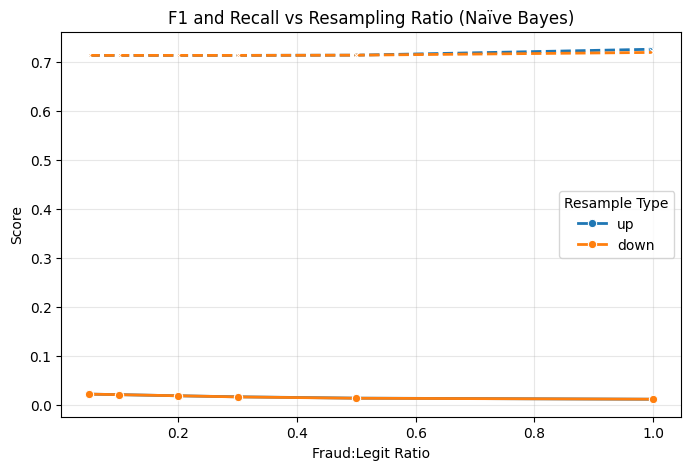

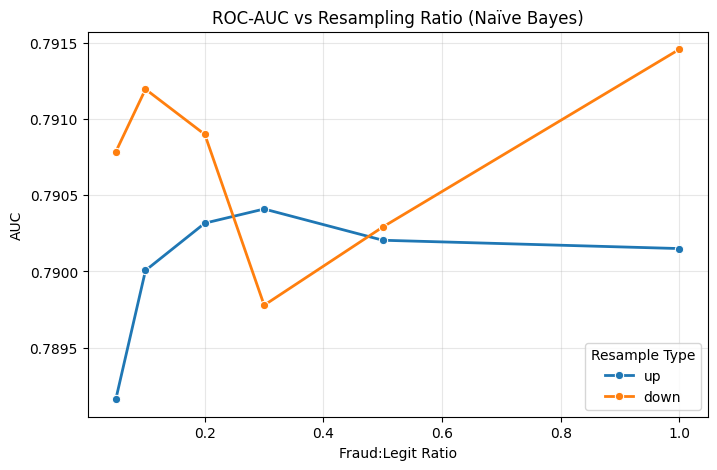

precision  recall     f1  roc_auc
ratio resample_type                                   
0.05  down               0.011   0.713  0.022    0.791
      up                 0.011   0.713  0.022    0.789
0.10  down               0.011   0.713  0.021    0.791
      up                 0.011   0.713  0.021    0.790
0.20  down               0.010   0.713  0.019    0.791
      up                 0.010   0.713  0.019    0.790
0.30  down               0.008   0.713  0.017    0.790
      up                 0.009   0.713  0.017    0.790
0.50  down               0.007   0.714  0.014    0.790
      up                 0.007   0.714  0.014    0.790
1.00  down               0.006   0.719  0.012    0.791
      up                 0.006   0.726  0.012    0.790

In [7]:
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False).reset_index(drop=True)
display(results_df.head(10))

results_df.to_csv("results/naive_bayes_results.csv", index=False)
print("Saved results to results/naive_bayes_results.csv")

# ---- Plot F1 & Recall vs Ratio ----
plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x="ratio", y="f1", hue="resample_type", marker="o", linewidth=2)
sns.lineplot(data=results_df, x="ratio", y="recall", hue="resample_type", marker="x", linestyle="--", linewidth=2, legend=False)
plt.title("F1 and Recall vs Resampling Ratio (Naïve Bayes)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.show()

# ---- Plot ROC-AUC vs Ratio ----
plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x="ratio", y="roc_auc", hue="resample_type", marker="o", linewidth=2)
plt.title("ROC-AUC vs Resampling Ratio (Naïve Bayes)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("AUC")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.show()

# ---- Summary Table ----
summary = results_df.groupby(["ratio", "resample_type"])[["precision", "recall", "f1", "roc_auc"]].mean().round(3)
display(summary)
